In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [2]:
# Load the pretrained ResNet-18 model
model = torch.load('resnet18_model.pt')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Modify the model to capture the feature maps and gradients from the last convolutional layer
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, model):
        super(ModifiedResNet18, self).__init__()
        self.features = list(model.children())[:-2] # all layers except the last two
        self.features = torch.nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.fc = model.fc
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

modified_model = ModifiedResNet18(model)

In [4]:
# Grad-CAM function
def grad_cam(modified_model, input_image, target_class):
    # Forward
    output = modified_model(input_image)
    target = output[:, target_class]

    # Backward
    modified_model.zero_grad()
    target.backward()

    # Get the gradients and activations
    gradients = modified_model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = modified_model.get_activations(input_image).detach()

    # Weighting the activations with the gradients and creating heatmap
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

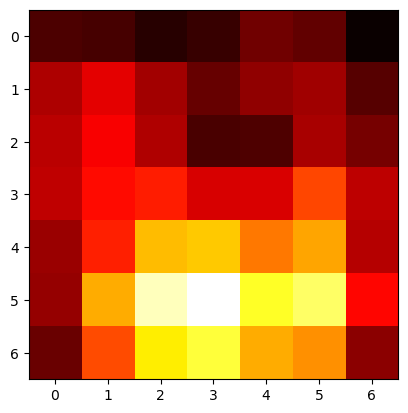

In [14]:
# Load and preprocess an image

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')  # Convert image to RGB if it's not
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = transform(img).unsqueeze(0)
    return img

input_image = preprocess_image('./NORMAL-4512-0001.jpeg')
target_class = 1 # Replace with the class you're interested in

# Apply Grad-CAM
heatmap = grad_cam(modified_model, input_image, target_class)

plt.imshow(heatmap, cmap='hot')
plt.show()

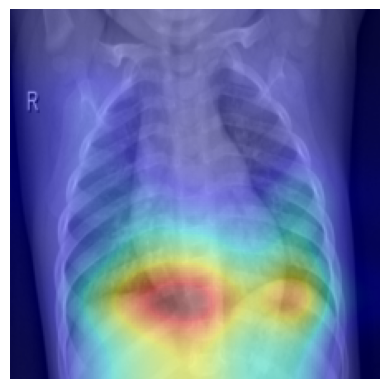

In [17]:
# Convert the heatmap to PIL image and resize
from torchvision.transforms.functional import to_pil_image
import PIL
from matplotlib import cm
import numpy as np

# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(to_pil_image(input_image.squeeze(), mode='RGB'))

# Resize the heatmap to the same size as the input image
overlay = to_pil_image(torch.from_numpy(heatmap), mode='F').resize(input_image.squeeze().shape[1:], resample=PIL.Image.BICUBIC)

# Apply a colormap (like 'jet') to the heatmap
cmap = cm.jet
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes with alpha < 1 (transparency)
ax.imshow(overlay, alpha=0.4, interpolation='nearest')

# Show the plot
plt.show()